## 프로젝트 기반 빅데이터 서비스 솔루션 개발 전문 과정

#### 교과목명 : 머신러닝알고리즘 이해 및 활용
- 평가일 : 03.10
- 성명 :이재호
- 점수 :70(7/10)

Q1. iris data를 불러와서 아래 사항을 수행하세요.(15점)

- 결정트리 모델을 시각화하고 주요한 인사이트를 기술하세요.(tree.plot_tree or tree.export_graphviz 이용)
- Feature importance를 추출하고 시각화하세요.

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

iris_data = load_iris()
X_train,X_test,y_train,y_test = train_test_split(iris_data.data,iris_data.target,
                                                test_size=0.2, random_state=11)
dt_clf =DecisionTreeClassifier(min_samples_leaf=4)
dt_clf.fit(X_train,y_train)
pred = dt_clf.predict(X_test)

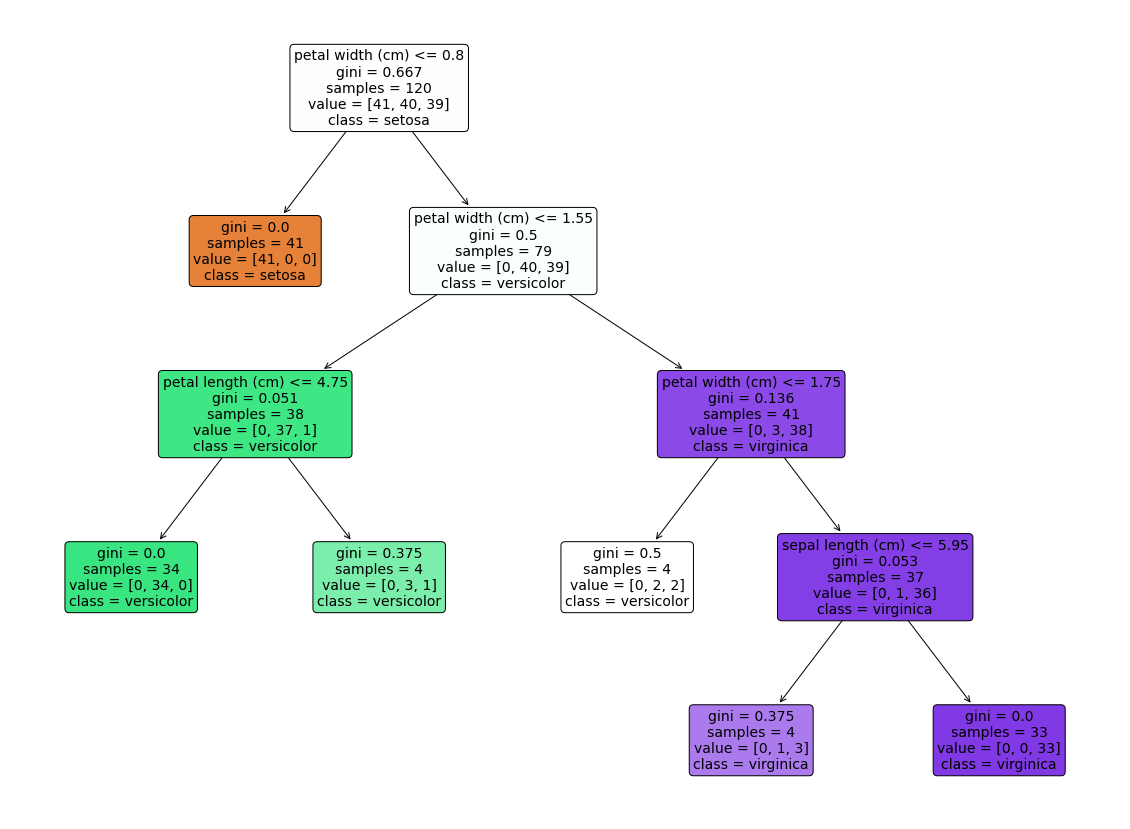

In [4]:
from sklearn import tree
import matplotlib.pyplot as plt
plt.figure(figsize=(20,15))
tree.plot_tree(dt_clf, filled=True,
              feature_names = iris_data.feature_names,
              class_names=iris_data.target_names,
              rounded=True, fontsize=14)

plt.show()
plt.close()

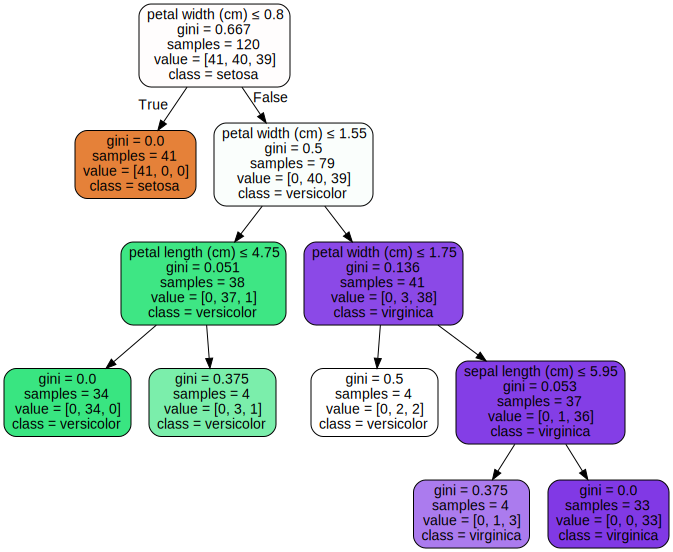

In [5]:
from sklearn import tree
import graphviz
dot_data = tree.export_graphviz(dt_clf,
                               out_file = None,
                               feature_names = iris_data.feature_names,
                               class_names = iris_data.target_names,
                               filled = True,
                               rounded = True,
                               special_characters = True)

graph = graphviz.Source(dot_data)
graph

Feature importance:
[0.0059 0.     0.006  0.9881]
sepal length (cm): 0.0059
sepal width (cm): 0.0000
petal length (cm): 0.0060
petal width (cm): 0.9881


<AxesSubplot:>

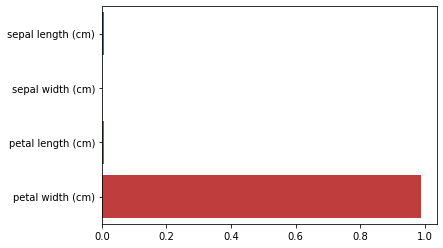

In [7]:
import seaborn as sns
import numpy as np

print('Feature importance:\n{0}'.\
     format(np.round(dt_clf.feature_importances_,4)))

for name, value in zip(iris_data.feature_names,\
                      dt_clf.feature_importances_):
    print('{0}: {1:.4f}'.format(name,value))
    
sns.barplot(x=dt_clf.feature_importances_, y =iris_data.feature_names)

Q2~Q3. 'dataset/creditcard.csv'를 불러와서 신용카드 사기 검출 분류문제를 아래와 같이 수행하세요(20점)
- 로지스틱 리그레션을 적용한 모델 학습 및 사용자 함수를 이용하여 평가
    - 인자로 입력받은 DataFrame을 복사한 뒤 Time 칼럼만 삭제하고 복사된 df 반환하는 사용자 함수 생성
    - 사전 데이터 가공 후 학습과 테스트 데이터 세트를 반환하는 함수(테스트 사이즈 0.3)
    - 오차행렬, 정확도, 정밀도, 재현율, f1, AUC 평가 함수
    
- 인자로 사이킷런의 Estimator 객체와 학습/테스트 데이터 세트를 입력 받아서  학습/예측/평가 수행
    - 사용자 함수를 사용하여 LightGBM으로 모델을 학습한 뒤 별도의 테스트 데이터 세트에서 예측 평가를 수행. 단, n_estimators=1000, num_leaves=64 적용<br>  ※ 레이블 값이 극도로 불균형한 분포를 가지고 있는 경우 boost_from_average=False로 파라미터 설정(default=True). default 설정은 재현율, AUC 성능을 매우 크게 저하시킴
    - 넘파이의 np.log1p( )를 이용하여 Amount를 로그 변환하는 사용자 함수 생성
    - Amount를 로그 변환 후 로지스틱 회귀 및 LightGBM 수행.

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

card_df = pd.read_csv('datasets/creditcard.csv')
card_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [9]:
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    df_copy.drop('Time', axis=1, inplace=True)
    return df_copy

In [11]:
from sklearn.model_selection import train_test_split
def get_train_test_dataset(df=None):
    df_copy = get_preprocessed_df(df)
    X_features = df_copy.iloc[:,:-1]
    y_target = df_copy.iloc[:,-1]
    X_train, X_test, y_train, y_test = train_test_split(X_features, y_target,
                                                       test_size=0.3, random_state=0,
                                                       stratify=y_target)
    return X_train,X_test, y_train,y_test
X_train,X_test,y_train,y_test = get_train_test_dataset(card_df)

In [12]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, \
f1_score, roc_auc_score

def get_clf_eval(y_test,pred,pred_proba):
    confusion = confusion_matrix(y_test,pred)
    accuracy = accuracy_score(y_test,pred)
    precision = precision_score(y_test,pred)
    recall = recall_score(y_test,pred)
    f1 = f1_score(y_test,pred)
    auc = roc_auc_score(y_test,pred_proba)
    print('오차 행렬\n',confusion)    
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, auc))

In [17]:
from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression()
lr_clf.fit(X_train,y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:,1]
get_clf_eval(y_test, lr_pred, lr_pred_proba)

오차 행렬
 [[85283    12]
 [   56    92]]
정확도: 0.9992, 정밀도: 0.8846, 재현율: 0.6216,    F1: 0.7302, AUC:0.9640


In [18]:
def get_model_train_eval(model, ftr_train=None, ftr_test=None,
                        tgt_train=None, tgt_test=None):
    model.fit(ftr_train,tgt_train)
    pred = model.predict(ftr_test)
    pred_proba=model.predict_proba(ftr_test)[:,1]
    get_clf_eval(tgt_test,pred,pred_proba)

In [20]:
from lightgbm import LGBMClassifier
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1,
                         boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test,
                    tgt_train= y_train, tgt_test = y_test)

오차 행렬
 [[85290     5]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9573, 재현율: 0.7568,    F1: 0.8453, AUC:0.9790


In [21]:
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
    return df_copy

In [22]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, 
                     tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, 
                     tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
 [[85283    12]
 [   59    89]]
정확도: 0.9992, 정밀도: 0.8812, 재현율: 0.6014,    F1: 0.7149, AUC:0.9727
### LightGBM 예측 성능 ###
오차 행렬
 [[85290     5]
 [   35   113]]
정확도: 0.9995, 정밀도: 0.9576, 재현율: 0.7635,    F1: 0.8496, AUC:0.9796


Q4. Q2 신용카드 사기 검출 분류문제에서 아래를 참고하여 이상치 데이터를 제거하고 모델 학습/예측/평가를 수행하세요(10점)
- 히트맵을 이용해 레이블과의 상관성을 시각화 
- 레이블과 상관성이 높은 피처를 위주로 이상치 검출하는 사용자 함수 생성
- 사용자 함수를 이용하여 이상치 검출
- 이상치 제거 사용자 함수를 이용하여 이상치 제거 후 로지스틱 회귀 및 LightGBM 수행 및 평가

<AxesSubplot:>

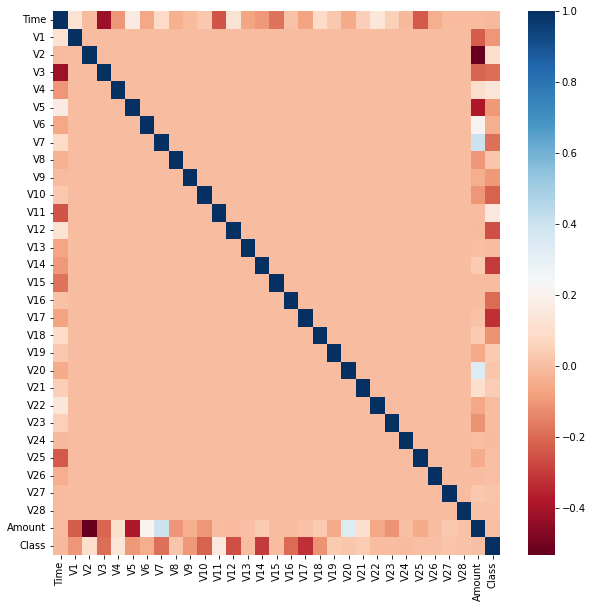

In [23]:
import seaborn as sns

plt.figure(figsize=(10,10))
corr = card_df.corr()

sns.heatmap(corr, cmap='RdBu')

In [28]:
import numpy as np

def get_outlier(df=None, column=None, weight=1.5):
    
    fraud = df[df.Class==1][column]
    qt_25 = np.percentile(fraud.values,25)
    qt_75 = np.percentile(fraud.values,75)
    
    iqr = qt_75 - qt_25
    iqr_weight =iqr*weight
    lowest_val = qt_25 - iqr_weight
    highest_val = qt_75 + iqr_weight
    
    outlier_index = fraud[(fraud<lowest_val) | (fraud > highest_val)].index
    return outlier_index

In [29]:
outlier_index = get_outlier(df=card_df, column='V14',weight=1.5)
print('이상치 데이터 인덱스:', outlier_index)

이상치 데이터 인덱스: Int64Index([8296, 8615, 9035, 9252], dtype='int64')


In [30]:
outlier_index = get_outlier(df=card_df, column='V17',weight=1.5)
print('이상치 데이터 인덱스:', outlier_index)

이상치 데이터 인덱스: Int64Index([], dtype='int64')


In [31]:
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_scaled', amount_n)
    df_copy.drop(['Time','Amount'],axis=1, inplace=True)
    
    outlier_index = get_outlier(df=df_copy, column='V14',weight=1.5)
    df_copy.drop(outlier_index, axis=0, inplace=True)
    return df_copy

X_train,X_test,y_train,y_test = get_train_test_dataset(card_df)
print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, 
                     tgt_train=y_train, tgt_test=y_test)
print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, 
                     tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
 [[85281    14]
 [   48    98]]
정확도: 0.9993, 정밀도: 0.8750, 재현율: 0.6712,    F1: 0.7597, AUC:0.9743
### LightGBM 예측 성능 ###
오차 행렬
 [[85290     5]
 [   25   121]]
정확도: 0.9996, 정밀도: 0.9603, 재현율: 0.8288,    F1: 0.8897, AUC:0.9780


Q5. SMOTE 오버 샘플링 적용 후 LightGBM 모델을 이용하여 학습, 예측, 평가를 수행하세요.(10점)

In [34]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_resample(X_train,y_train)
print('SMOTE 적용전:', X_train.shape, y_train.shape)
print('SMOTE 적용후:', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용후 레이블 값 분포:\n',pd.Series(y_train_over).value_counts())

SMOTE 적용전: (199362, 29) (199362,)
SMOTE 적용후: (398040, 29) (398040,)
SMOTE 적용후 레이블 값 분포:
 0    199020
1    199020
Name: Class, dtype: int64


Q6. 사이킷런에서 제공해주는 load_boston 데이터셋을 가져와서 아래 사항을 수행하세요.(10점)
- 데이터셋의 타겟 이름을 'PRICE'로 지정한 후 데이터프레임을 생성 pickle 파일로 저장 후 다시 불어오세요.
- 히트맵을 이용하여 타겟과 상관관계가 높은 독립 변수를 선택하세요.
- 종속변수를 로그 변환하세요
- 위의 사항을 반영하여 선회회귀 모델을 생성 후 평가하고 회귀계수를 출력하세요.

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_boston

house = load_boston()
house.keys()

house_df = pd.DataFrame(house.data, columns = house.feature_names)
house_df['PRICE'] = house.target
house_df.to_pickle('./dataset/house_df.pkl')
house_df = pd.read_pickle('./dataset/house_df.pkl')
house_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


<AxesSubplot:title={'center':'Correlation'}>

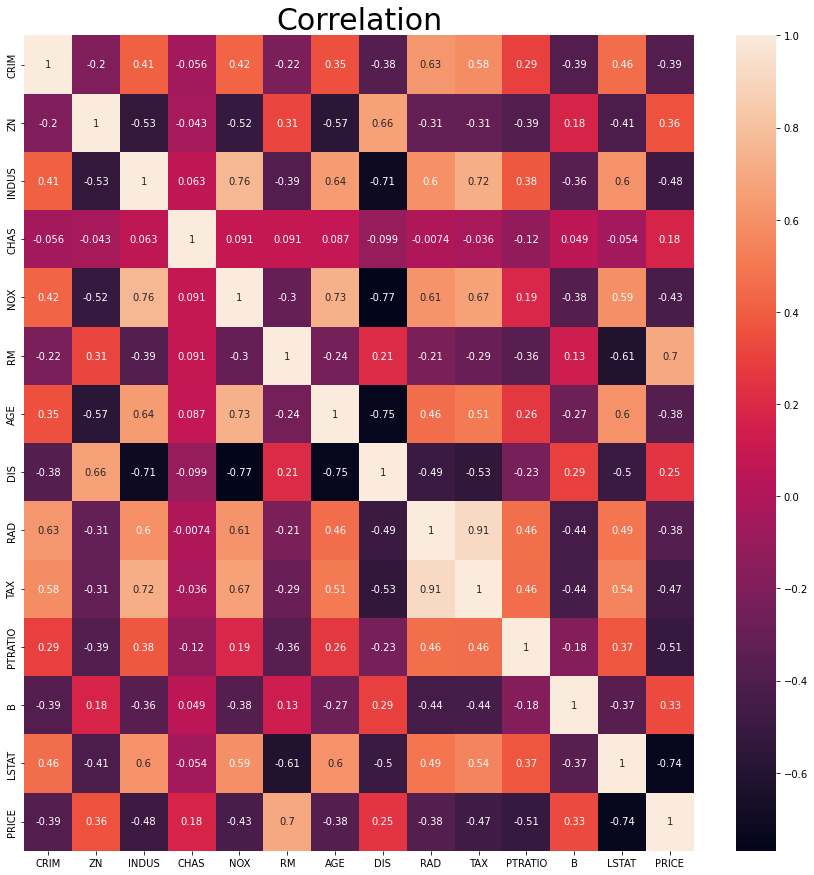

In [41]:
plt.figure(figsize=(15,15))
plt.title('Correlation', fontsize=30)
sns.heatmap(house_df.corr(), annot=True)

In [44]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

X = house_df[['RM','ZN','INDUS','NOX','AGE','PTRATIO','LSTAT','RAD']]
y = house_df['PRICE']
y_log = np.log1p(house_df['PRICE'])

X_train,X_test,y_train,y_test = \
train_test_split(X,y_log,test_size=0.3, random_state=1)

lr = LinearRegression()
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
y_test_exp = np.expm1(y_test)
y_pred_exp = np.expm1(y_pred)

mse = mean_squared_error(y_test_exp, y_pred_exp)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_exp, y_pred_exp)
print('MSE: {:.3f}, RMSE:{:.3f}, R2 score : {:.3f}'.format(mse,rmse,r2))
print('절편 값:', lr.intercept_)
print('회귀 계수값:', np.round(lr.coef_,1))

MSE: 24.572, RMSE:4.957, R2 score : 0.732
절편 값: 4.161068564990526
회귀 계수값: [ 0.1 -0.   0.  -0.7  0.  -0.  -0.   0. ]


Q7. house_df.pkl 데이터셋을 불러와서 아래사항을 수행하세요.(15점)
- alphas = [0, 0.1, 1, 10, 100] 를 적용하여 Ridge 회귀 모델링 및 교차 검증 수행 후 5 폴드 평균 RMSE 출력 
- lasso_alphas = [0.07,0.1,0.5,1,3] 를 적용, Lasso 회귀 모델링 및 교차 검증 수행 후 5 폴드 평균 RMSE 출력(def get_linear_reg_eval(model_name,params=None,X_data_n=None, y_target_n=None, verbose=True 사용자 함수 이용) 
- elastic_alphas = [0.07,0.1,0.5,1,3] 를 적용, ElasticNet 회귀 모델링 및 교차검증 후 5 폴드 평균 RMSE를 출력(사용자 함수 이용)

Q8. load_boston 데이터셋을 불러와서 다음사항을 수행하세요.
- SVM 알고리즘을 활용한 주택가격 예측모델 생성 및 평가(MSE, RMSE, R2)
- 개발된 예측모델을 활용하여 아래 test_data가 주어졌은때의 주택가격 예측<br>
test_data = [3.7, 0, 18.4, 1, 0.87, 5.95, 91, 2.5052, 26, 666, 20.2, 351.34, 15.27]

In [48]:
import numpy as np
from sklearn import datasets
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.utils import shuffle

data = datasets.load_boston()

X,y = shuffle(data.data, data.target, random_state = 7)

num_training = int(0.8 * len(X))
X_train, y_train = X[:num_training], y[:num_training]
X_test, y_test = X[num_training:], y[num_training:]

sv_regressor = SVR(kernel = 'linear', C=1.0, epsilon=0.1)

sv_regressor.fit(X_train, y_train)

y_pred = sv_regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print(f'mse:{mse:.3f}','\n')
print(f'rmse:{rmse:.3f}','\n')
print(f'r2:{r2:.3f}','\n')
test_data = [3.7, 0, 18.4, 1, 0.87, 5.95, 91, 2.5052, 26, 666, 20.2, 351.34, 15.27]
print('예측값:', np.round(sv_regressor.predict([test_data])[0],3))

mse:15.377 

rmse:3.921 

r2:0.813 

예측값: 18.522


Q9. mtcars 데이터셋(mtcars.csv)의 qsec 컬럼을 최소최대 척도(Min-Max Scale)로 변환한 후 0.5보다 
큰 값을 가지는 레코드 수를 구하시오

Q10. purdata.csv는 백화점 고객의 1년 간 구매 데이터이다. 아래사항을 수행하세요.
 
- 남성고객을 분류하는 모델을 생성(분류알고리즘 : dt,rf,lr)
- 모델 성능을 roc_auc로 평가 